In [1]:
import os
import torch
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
import torch.nn as nn

from Encoder import Encoder, reparameterize
from Generator import Generator
from Discriminator import BigJointDiscriminator

from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import ToTensor, Compose, Resize, Normalize

from tqdm.notebook import tqdm
import seaborn as sns

In [12]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [63]:
class InvertiblePriorLinear(nn.Module):
    def __init__(self):
        super(InvertiblePriorLinear, self).__init__()
        self.a = torch.rand(1, device = device)
        self.b = torch.rand(1, device = device)

    def forward(self, eps):
        o = self.a * eps + self.b
        return o
    def inverse(self, o):
        eps = (o - self.b)/self.a
        return eps

class InvertiblePriorInv(nn.Module):
    """docstring for InvertiblePrior"""
    def __init__(self,prior):
        super(InvertiblePriorInv, self).__init__()
        self.prior = prior
    def forward(self, o):
        return self.prior.inverse(o)
    def inverse(self, eps):
        return self.prior(eps)


class SCM(nn.Module):
    def __init__(self, d, A=None, scm_type='mlp'):
        super().__init__()
        self.d = d
        self.A_given = A
        self.A_fix_idx = A == 0
        self.A = nn.Parameter(torch.zeros(d, d))

        prior_net_model = lambda : InvertiblePriorLinear()
        prior_net_enc_model = lambda x: InvertiblePriorInv(x)
        
        for i in range(d):
            setattr(self, "prior_net%d" % i, prior_net_model())
            setattr(self, "enc_net%d" % i, prior_net_enc_model(getattr(self, "prior_net%d" % i)))

    def set_zero_grad(self):
        if self.A_given is None:
            pass
        else:
            for i in range(self.d):
                for j in range(self.d):
                    if self.A_fix_idx[i, j]:
                        self.A.grad.data[i, j].zero_()

    def prior_nlr(self, z):
        '''Nonlinear transformation f_2(z)'''
        zs = torch.split(z, 1, dim=1)
        z_new = []
        for i in range(self.d):
            z_new.append(getattr(self, "prior_net%d" % i)(zs[i]))
        return torch.cat(z_new, dim=1)

    def enc_nlr(self, z):
        '''f_2^{-1}(z)'''
        zs = torch.split(z, 1, dim=1)
        z_new = []
        for i in range(self.d):
            z_new.append(getattr(self, "enc_net%d" % i)(zs[i]))
        return torch.cat(z_new, dim=1)

    def mask(self, z): # Az
        z = torch.matmul(z, self.A)
        return z

    def inv_cal(self, eps): # (I-A)^{-1}*eps
        adj_normalized = torch.inverse(torch.eye(self.A.shape[0], device=self.A.device) - self.A)
        z_pre = torch.matmul(eps, adj_normalized)
        return z_pre

    def get_eps(self, z):
        '''Returns epsilon from f_2^{-1}(z)'''
        return torch.matmul(z, torch.eye(self.A.shape[0], device=self.A.device) - self.A)

    def intervene(self, z, z_ori):
        # f_2^{-1}(z)
        z_ori = self.enc_nlr(z_ori)
        z = self.enc_nlr(z)
        # masked nonlinear z
        z_new = self.mask(z)
        z_new = z_new + self.get_eps(z_ori)
        return self.prior_nlr(z_new)

    def forward(self, eps=None, z=None):
        if eps is not None and z is None:
            # (I-A.t)^{-1}*eps
            z = self.inv_cal(eps) # n x d
            # nonlinear transform
            return self.prior_nlr(z)
        else:
            # f_2^{-1}(z)
            z = self.enc_nlr(z)
            # mask z
            z_new = self.mask(z) # new f_2^{-1}(z) (without noise)
            return z_new, z

In [64]:
class ImageDataset(Dataset):
    def __init__(self,root_folder,transform, cols = None):
        self.transform=transform
        self.img_folder=root_folder+'img/'

        self.image_names=[i for i in os.listdir(self.img_folder) if '.jpg' in i]
        self.attr = pd.read_csv(root_folder+'attr.csv').replace(-1,0)
        _ = self.attr.pop('image_id')
        if cols is not None:
            self.attr = self.attr[cols]    
        self.num_feat = len(self.attr.columns)
        self.order = list(self.attr.columns)
        
        self.attr = self.attr.values
   
    def __len__(self):
        return len(self.image_names)
 
    def __getitem__(self, index):
        image_path = self.img_folder + self.image_names[index]
        image=Image.open(image_path)
        image=self.transform(image)
        label = torch.tensor(self.attr[index], dtype = torch.float)

        return image, label

def get_train_dataloader(root_folder, img_dim=64, batch_size=32, cols = None):

    transform = Compose([Resize((img_dim, img_dim)),
                        ToTensor(),
                        Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    training_data = ImageDataset(root_folder='sample_data/',transform=transform, cols = cols)
    train_dataloader = DataLoader(training_data, batch_size = batch_size)
    return train_dataloader

In [65]:
cols = ['Smiling', 'Male', 'High_Cheekbones', 'Mouth_Slightly_Open', 'Narrow_Eyes', 'Chubby']

In [66]:
root_folder = 'sample_data/'

in_channels = 3
fc_size = 2048
latent_dim = 100

img_dim = 64
batch_size = 32

num_label = len(cols)

In [67]:
train_dataloader = get_train_dataloader(root_folder, img_dim=img_dim, batch_size=batch_size, cols = cols)

In [68]:
A = torch.zeros((num_label, num_label), device = device)
A[0, 2:6] = 1
A[1, 4] = 1

In [69]:
A

tensor([[0., 0., 1., 1., 1., 1.],
        [0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.]], device='cuda:0')

In [70]:
e = Encoder(latent_dim = latent_dim, fc_size = fc_size).to(device)
g = Generator(latent_dim = latent_dim, image_size = img_dim).to(device)
disc = BigJointDiscriminator(latent_dim = latent_dim, image_size = img_dim).to(device)

In [71]:
prior = SCM(num_label, A, scm_type='linscm').to(device)
prior_param = list(prior.parameters())
A_optimizer = optim.Adam(prior_param[0:1], lr=5e-4)
p_optimizer = optim.Adam(prior_param[1:],  lr=5e-4, betas=(0, 0.999))

In [72]:
e_optimizer = optim.Adam(e.parameters(), lr=5e-5, betas=(0, 0.999))
g_optimizer = optim.Adam(g.parameters(), lr=5e-5, betas=(0, 0.999))
d_optimizer = optim.Adam(disc.parameters(), lr=1e-4, betas=(0, 0.999))

In [73]:
num = len(train_dataloader.dataset)//batch_size

epochs = 5

In [74]:
disc_steps = 1
g_steps = 1
e_steps = 1

celoss = torch.nn.BCEWithLogitsLoss()

In [75]:
for epoch in tqdm(range(epochs)):
    disc_loss, e_loss, g_loss = [], [], []
    
    e.train()
    g.train()
    disc.train()
    with torch.autograd.set_detect_anomaly(True):
        for (X, label) in tqdm(train_dataloader, total = num):        
            X = X.to(device)

            sup_flag = label[:, 0] != 0
            if sup_flag.sum() > 0:
                label = label[sup_flag, :].float()
            label = label.to(device)

            for _ in range(disc_steps):
                disc.zero_grad()

                z = torch.randn(X.shape[0], latent_dim, device=device)

                mu, sigma = e(X)
                z_fake = reparameterize(mu, sigma )

                label_z = prior(z[:, :num_label])
                other_z = z[:, num_label:]
                z = torch.cat([label_z, other_z], dim=1)

                X_fake = g(z)

                e_score = disc(X, z_fake.detach())
                g_score = disc(X_fake.detach(), z.detach())

                del z_fake
                del X_fake

                loss_d = F.softplus(g_score).mean() + F.softplus(-e_score).mean()
                loss_d.backward()
                d_optimizer.step()
                disc_loss.append(loss_d.item())

            #___________________________________
            for _ in range(e_steps):
                z = torch.randn(X.size(0), latent_dim, device=device)
                mu, sigma = e(X)
                z_fake = reparameterize(mu, sigma )

                g.zero_grad()
                e.zero_grad()
                prior.zero_grad()

                e_score = disc(X, z_fake)
                l_encoder = e_score.mean()

                label_z = prior(z[:, :num_label])
                other_z = z[:, num_label:]
                z = torch.cat([label_z, other_z], dim=1)

                X_fake = g(z)
                label_z = mu[sup_flag, :num_label]
                sup_loss = celoss(label_z, label)

                l_encoder = l_encoder + sup_loss * 5
                l_encoder.backward()

                e_loss.append(l_encoder.item())
                e_optimizer.step()
                p_optimizer.step()

                g_score = disc(X_fake, z)
                s_decoder = torch.exp(g_score.detach()).clamp(0.5, 2)
                loss_decoder = -(s_decoder * g_score).mean()
                g_loss.append(loss_decoder.item())
                loss_decoder.backward()
                g_optimizer.step()

                prior.set_zero_grad()
                A_optimizer.step()
                p_optimizer.step()
        
        print(f"[{epoch+1}/{epochs}] Encoder Loss : {sum(e_loss)/num:>.5f} Gen Loss : {sum(g_loss)/num:>.5f} Disc Loss : {sum(disc_loss)/num:>.5f}")

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/316 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/torch/autograd/__init__.py:199: UserWarning: Error detected in MulBackward0. Traceback of forward call that caused the error:
  File "/opt/conda/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/opt/conda/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "/opt/conda/lib/python3.7/site-packages/traitlets/config/application.py", line 1043, in launch_instance
    app.start()
  File "/opt/conda/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 712, in start
    self.io_loop.start()
  File "/opt/conda/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 215, in start
    self.asyncio_loop.run_forever()
  File "/opt/conda/lib/python3.7/asyncio/base_events.py", line 541, in run_forever
    self._run_once()
  File "/opt/conda/lib/python3.7/asyn

RuntimeError: one of the variables needed for gradient computation has been modified by an inplace operation: [torch.cuda.FloatTensor [1]] is at version 2; expected version 1 instead. Hint: the backtrace further above shows the operation that failed to compute its gradient. The variable in question was changed in there or anywhere later. Good luck!

In [ ]:
def plot_image(fake):
    with torch.no_grad():
        fake = np.transpose(fake.cpu().numpy(), (0, 2, 3, 1))
    _,ax = plt.subplots(1, 10, figsize=(24,4))
    for i in range(10):
        ax[i].imshow(fake[i])
    plt.show()

In [ ]:
for X, label in train_dataloader:
    mu, sigma = e(X.to(device))
    z = reparameterize(mu, sigma)
    label_z = prior(z[:, :num_label])
    other_z = z[:, num_label:]
    z = torch.cat([label_z, other_z], dim=1)
    x_fake = g(z)
    x_fake = (x_fake * 0.5) + 0.5
    plot_image(x_fake)
    print(z[:10,:num_label], label[:10])
    break

In [77]:
print(A)
print(prior.A.data.to(device='cpu'))

tensor([[0., 0., 1., 1., 1., 1.],
        [0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.]], device='cuda:0')
tensor([[ 0.0000,  0.0000,  0.0005,  0.0005, -0.0005, -0.0005],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0005,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000]])


<AxesSubplot:>

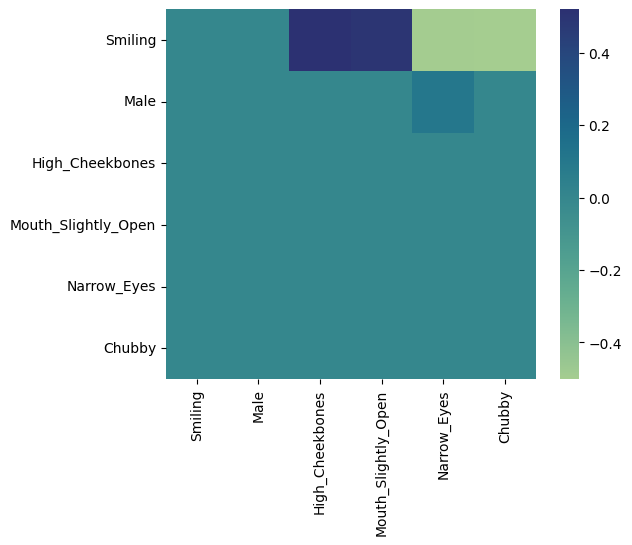

In [62]:
sns.heatmap(prior.A.data.to(device='cpu'),cmap="crest",
            square='True', xticklabels = cols, yticklabels = cols)